# Dataset Exploration

In [1]:
import os

default_n_threads = 8
os.environ["OPENBLAS_NUM_THREADS"] = f"{default_n_threads}"
os.environ["MKL_NUM_THREADS"] = f"{default_n_threads}"
os.environ["OMP_NUM_THREADS"] = f"{default_n_threads}"

%load_ext autoreload
%autoreload 2

In [24]:
from toolbox import init, newfig

init(style="beamer.mplstyle")

SAVEDIR = "/Users/leo/Workspace/phdcybersec/slides_ares_2024/src/figures/"

In [3]:
import pandas as pd

df_sampled = pd.read_csv("../../../data/nfv2/sampled/cicids.csv.gz")
df_full = pd.read_csv("../../../data/nfv2/origin/NF-CSE-CIC-IDS2018-v2.csv.gz")

In [4]:
df_sampled["Attack"] = df_sampled["Attack"].apply(
    lambda x: {
        "Benign": "Benign",
        "DDoS": "DDoS",
        "DoS": "DoS",
        "Bot": "Bot",
        "Brute Force": "Brute Force",
        "Infilteration": "Infiltration",
        "injection": "Injection",
    }[x]
)

df_full["Attack"] = df_full["Attack"].apply(
    lambda x: {
        "Benign": "Benign",
        "DDOS attack-HOIC": "DDoS",
        "DoS attacks-Hulk": "DoS",
        "DDoS attacks-LOIC-HTTP": "DDoS",
        "Bot": "Bot",
        "Infilteration": "Infiltration",
        "SSH-Bruteforce": "Brute Force",
        "DoS attacks-GoldenEye": "DoS",
        "FTP-BruteForce": "Brute Force",
        "DoS attacks-SlowHTTPTest": "DoS",
        "DoS attacks-Slowloris": "DoS",
        "Brute Force -Web": "Brute Force",
        "DDOS attack-LOIC-UDP": "DDoS",
        "Brute Force -XSS": "Brute Force",
        "SQL Injection": "Injection",
    }[x]
)

## RQ0: Is the experiment sound?

Dataset analysis of CICIDS full and sampled. We chose sampled because of the scale of the experiments, but are the results still valid?

## Test methodology
- statistical analysis of the dataset, and comparison of the sampled dataset with the full dataset
  - plot PCA, potentially with colored labels
  - plot correlation matrix
  - plot distribution of labels
- Dispersion analysis (see RQ1) -> interpretability of results

In [5]:
stats_full = df_full["Attack"].value_counts()
stats_full.name = "Full"
stats_sampled = df_sampled["Attack"].value_counts()
stats_sampled.name = "Sampled"


stats = pd.DataFrame(
    [df_sampled["Attack"].value_counts(), df_full["Attack"].value_counts()]
)
stats = stats.T
stats.columns = ["Sampled", "Full"]
stats = pd.concat(
    [
        stats,
        pd.DataFrame(
            {"Sampled": sum(stats["Sampled"]), "Full": sum(stats["Full"])},
            index=["Total"],
        ),
    ]
)
stats

,Sampled,Full
Benign,880623,16635567
DDoS,73558,1390270
DoS,25574,483999
Bot,7595,143097
Brute Force,6525,123982
Infiltration,6108,116361
Injection,17,432
Total,1000000,18893708


Text(0.5, 0.0, 'Full dataset')

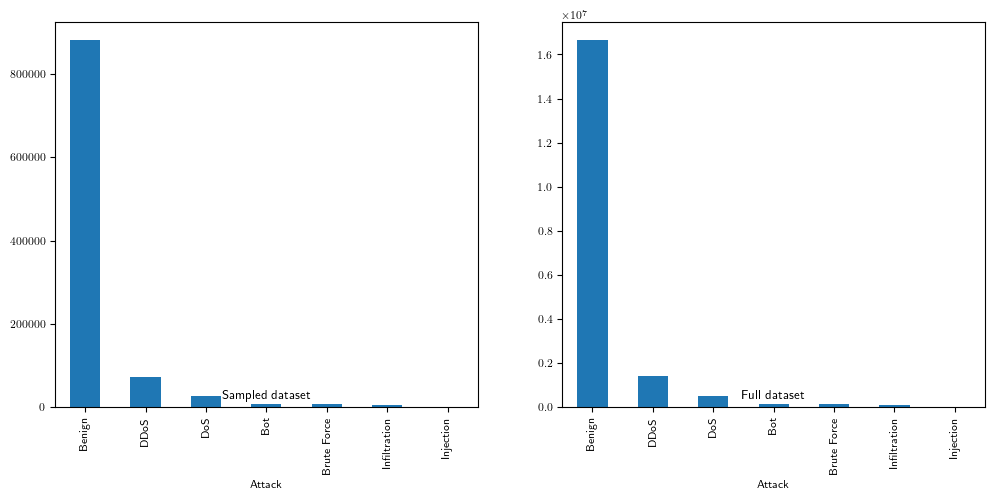

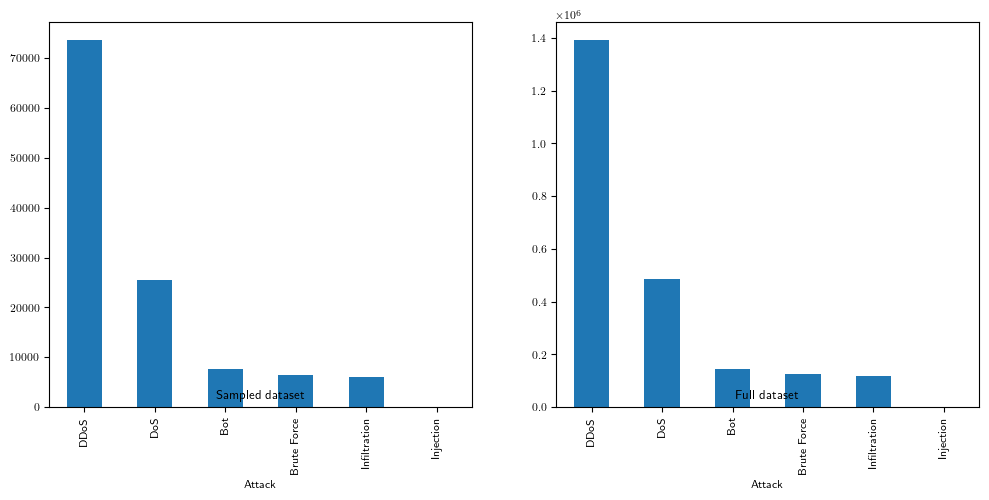

In [6]:
import matplotlib.pyplot as plt

# plot label distribution of both datasets
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
df_sampled["Attack"].value_counts().plot.bar(ax=axs[0])
axs[0].set_title("Sampled dataset")
df_full["Attack"].value_counts().plot.bar(ax=axs[1])
axs[1].set_title("Full dataset")

df_sampled_attack = df_sampled[df_sampled["Label"] == 1]
df_full_attack = df_full[df_full["Label"] == 1]

# plot label distribution wihout benign
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
df_sampled_attack["Attack"].value_counts().plot.bar(ax=axs[0])
axs[0].set_title("Sampled dataset")
df_full_attack["Attack"].value_counts().plot.bar(ax=axs[1])
axs[1].set_title("Full dataset")
# fig.savefig(SAVEDIR + "label-distribution.pgf")

Label distribution is identical (they only differ in magnitude) between sampled and full dataset; the different classes have been correctly sampled.

In [7]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler


def prepare(df) -> pd.DataFrame:
    RM_COLS = [
        "IPV4_SRC_ADDR",
        "L4_SRC_PORT",
        "IPV4_DST_ADDR",
        "L4_DST_PORT",
        "Label",
        "Attack",
    ]

    if "Dataset" in df.columns:
        RM_COLS += ["Dataset"]

    # select the columns to compose the Dataset object
    X = df.drop(columns=RM_COLS)

    # convert classes to numerical values
    X = pd.get_dummies(X)

    # normalize the data
    scaler = MinMaxScaler()
    scaler.fit(X)
    X[X.columns] = scaler.transform(X)

    return X


X_sampled = prepare(df_sampled_attack)
X_full = prepare(df_full_attack)
X_sampled.name = "sampled"
X_full.name = "full"

dfs = [
    (X_sampled, df_sampled_attack[["Attack"]]),
    (X_full, df_full_attack[["Attack"]]),
]


pca = PCA(n_components=2)
pcas = np.empty((2, 2), dtype=object)

for i, (from_df, _) in enumerate(dfs):
    frame = pca.fit(from_df)

    for j, (to_df, attack_df) in enumerate(dfs):
        projected = frame.transform(to_df)
        pcas[i, j] = pd.concat(
            [
                pd.DataFrame(
                    data=projected,
                    columns=["pc1", "pc2"],
                ),
                attack_df,
            ],
            axis=1,
        )
        pcas[i, j].name = f"'{from_df.name}' to '{to_df.name}'"

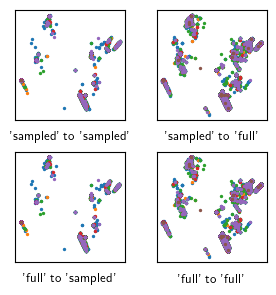

In [26]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.axes import Axes

fig = newfig(width=0.45, format=1 / 1)
axs: np.ndarray = fig.subplots(2, 2, sharex=True, sharey=True)

titles = []
for i, j in np.ndindex(axs.shape):
    pca_df = pcas[i, j]

    for attack in df_sampled_attack["Attack"].unique():
        df = pca_df[pca_df["Attack"] == attack]
        ax: Axes = axs[i, j]
        ax.scatter(
            df["pc1"],
            df["pc2"],
            label=attack,
            s=2,
            rasterized=True,  # rasterize the points because loading that many points is slow in vector format (even loading the generated PDF)
        )
        ax.set_yticklabels([])
        ax.set_xticklabels([])

    titles.append(axs[i, j].set_title(pca_df.name, pad=-15))

abc = "abcdefghijklmnopqrstuvwxyz"
for i, ax in enumerate(axs.flatten()):
    letter = abc[axs.flatten().tolist().index(ax)]
    ax.tick_params(labelbottom=True)
    # t = ax.set_title(r"\textbf{%s}" % f"({letter}) {ax.get_title()}", pad=-15)
    # titles.append(t)
    ax.set_aspect(1.0 / ax.get_data_ratio(), "box")
    ax.xaxis.set_tick_params(length=0)
    ax.yaxis.set_tick_params(length=0)

handles, labels = axs[0, 0].get_legend_handles_labels()

fig.savefig(
    SAVEDIR + "pca-projection.pdf",
    dpi=300,
    bbox_extra_artists=(*titles,),
    bbox_inches="tight",
)

PCA analysis on each dataset produced similar projections.
There are massive overlaps between the classes in this projection (showing either that 2 dimensions are not enough to separate the classes, or that there are features that are not relevant to the classification task).

Yet, the projected patterns are identical between the two datasets.
This means that the sampled dataset is representative of the full dataset.

Additionally, computing the PCA's projection from one dataset and applying it to the other produces the same results.
This emphasizes the fact that the two datasets are similar.

## RQ6: Is model similarity enough to detect poisoning attacks?

In order to prepare for **RQ6** (Is model similarity enough to detect poisoning attacks?), play around with the dataset and understand its characteristics, such as:

- Number of unique IPs
- Attack repartition per IP

In [9]:
df_sampled.head()

,IPV4_SRC_ADDR,L4_SRC_PORT,IPV4_DST_ADDR,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,IN_PKTS,OUT_BYTES,OUT_PKTS,...,TCP_WIN_MAX_OUT,ICMP_TYPE,ICMP_IPV4_TYPE,DNS_QUERY_ID,DNS_QUERY_TYPE,DNS_TTL_ANSWER,FTP_COMMAND_RET_CODE,Label,Attack,Dataset
0,212.92.115.177,49171,172.31.68.13,3389,6,0.000,1460,8,2126,10,...,64000,0,0,0,0,0,0.0,0,Benign,NF-CSE-CIC-IDS2018-v2
1,212.92.116.6,60992,172.31.67.115,3389,6,0.000,1830,10,3600,12,...,64000,29184,114,0,0,0,0.0,0,Benign,NF-CSE-CIC-IDS2018-v2
2,172.31.65.117,54899,172.31.0.2,53,17,5.126,71,1,87,1,...,0,0,0,45060,1,60,0.0,0,Benign,NF-CSE-CIC-IDS2018-v2
3,172.31.67.56,51920,209.85.202.113,80,6,7.126,1136,17,1450,15,...,42780,49920,195,0,0,0,0.0,0,Benign,NF-CSE-CIC-IDS2018-v2
4,5.101.40.43,60596,172.31.67.24,3389,6,0.000,1460,8,1873,7,...,64000,0,0,0,0,0,0.0,0,Benign,NF-CSE-CIC-IDS2018-v2


In [10]:
protocol_map = {
    6: "TCP",
    17: "UDP",
    1: "ICMP",
    2: "IGMP",  # Internet Group Management Protocol (used for multicast)
    58: "ICMPv6",
    47: "GRE",  # Generic Routing Encapsulation (Cisco tunneling protocol)
}
df_sampled["PROTOCOL"].value_counts().rename(index=protocol_map)

PROTOCOL
TCP       585038
UDP       413795
ICMP        1040
IGMP          74
ICMPv6        51
GRE            2
Name: count, dtype: int64

In [11]:
df_sampled[df_sampled["Label"] == 0]["L7_PROTO"].round().astype(int).value_counts()[
    lambda x: x > 100
]

L7_PROTO
0      580211
5      125605
91      69232
7       57175
41      27810
77       7920
88       3721
92       2928
131      1907
6         962
10        543
20        342
89        311
114       255
40        175
1         160
Name: count, dtype: int64

Text(0.5, 0.98, 'Explained variance ratio of the principal components')

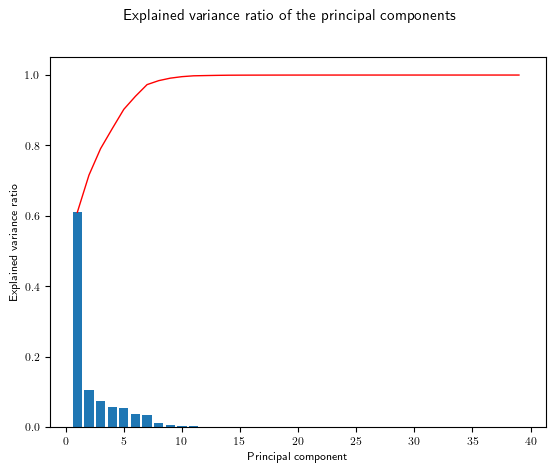

In [12]:
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler


def prepare(df) -> pd.DataFrame:
    RM_COLS = [
        "IPV4_SRC_ADDR",
        "L4_SRC_PORT",
        "IPV4_DST_ADDR",
        "L4_DST_PORT",
        "Label",
        "Attack",
    ]

    if "Dataset" in df.columns:
        RM_COLS += ["Dataset"]

    # select the columns to compose the Dataset object
    X = df.drop(columns=RM_COLS)

    # convert classes to numerical values
    X = pd.get_dummies(X)

    # normalize the data
    scaler = MinMaxScaler()
    # scaler = StandardScaler()
    scaler.fit(X)
    X[X.columns] = scaler.transform(X)

    # NaN values are replaced by 0
    X = X.fillna(0)

    return X


X = prepare(df_sampled[df_sampled["Label"] == 0])

pca = PCA()
pca.fit(X)

fig, ax = plt.subplots()
# plot the explained variance per principal component
ax.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_)
ax.set_ylabel("Explained variance ratio")
# plot the cumulative explained variance
ax.plot(
    range(1, len(pca.explained_variance_ratio_) + 1),
    pca.explained_variance_ratio_.cumsum(),
    c="red",
)

ax.set_xlabel("Principal component")
fig.suptitle("Explained variance ratio of the principal components")

Text(0.5, 0.98, 'Projection of the benign traffic using PCA (2 components)')

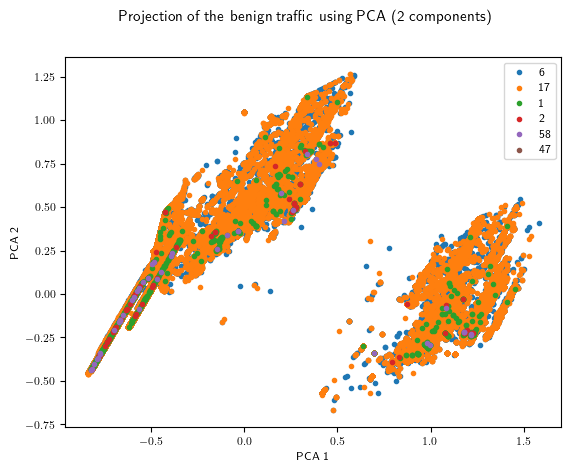

In [13]:
pca = PCA(n_components=2)
pca.fit(X)


# plot the pca colored by the protocol
X_pca = pca.transform(X)
X_pca = pd.DataFrame(X_pca, columns=["pca1", "pca2"])

fig, ax = plt.subplots()

for attack in df_sampled["PROTOCOL"].unique():
    mask = df_sampled["PROTOCOL"] == attack
    ax.scatter(
        X_pca.loc[mask, "pca1"],
        X_pca.loc[mask, "pca2"],
        label=attack,
    )
ax.set_xlabel("PCA 1")
ax.set_ylabel("PCA 2")

ax.legend()
fig.suptitle("Projection of the benign traffic using PCA (2 components)")

Text(0.5, 0.98, 'Projection of the benign traffic using PCA (2 components)')

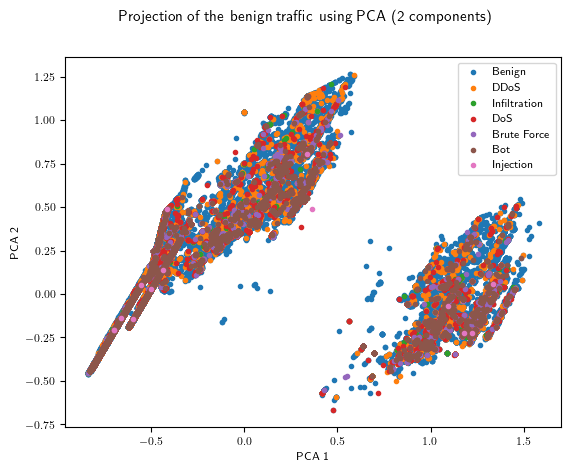

In [14]:
pca = PCA(n_components=2)
pca.fit(X)


# plot the pca colored by the protocol
X_pca = pca.transform(X)
X_pca = pd.DataFrame(X_pca, columns=["pca1", "pca2"])

fig, ax = plt.subplots()

for attack in df_sampled["Attack"].unique():
    mask = df_sampled["Attack"] == attack
    ax.scatter(
        X_pca.loc[mask, "pca1"],
        X_pca.loc[mask, "pca2"],
        label=protocol_map[attack] if attack in protocol_map else attack,
    )
ax.set_xlabel("PCA 1")
ax.set_ylabel("PCA 2")

ax.legend()
fig.suptitle("Projection of the benign traffic using PCA (2 components)")

In [15]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

kmeans = KMeans(n_clusters=10, init="k-means++", n_init=10)

kmeans.fit(X)
clusters = pd.DataFrame(kmeans.predict(X), columns=["X"])

kmeans.fit(X_pca)
clusters["X_pca"] = kmeans.predict(X_pca)

clusters["X"]

# rand index between "X" and "X_pca"
adjusted_rand_score(clusters["X"], clusters["X_pca"])

0.5865274446753714

Text(0.5, 0.98, 'Projection of the benign traffic using PCA (2 components) colored by cluster')

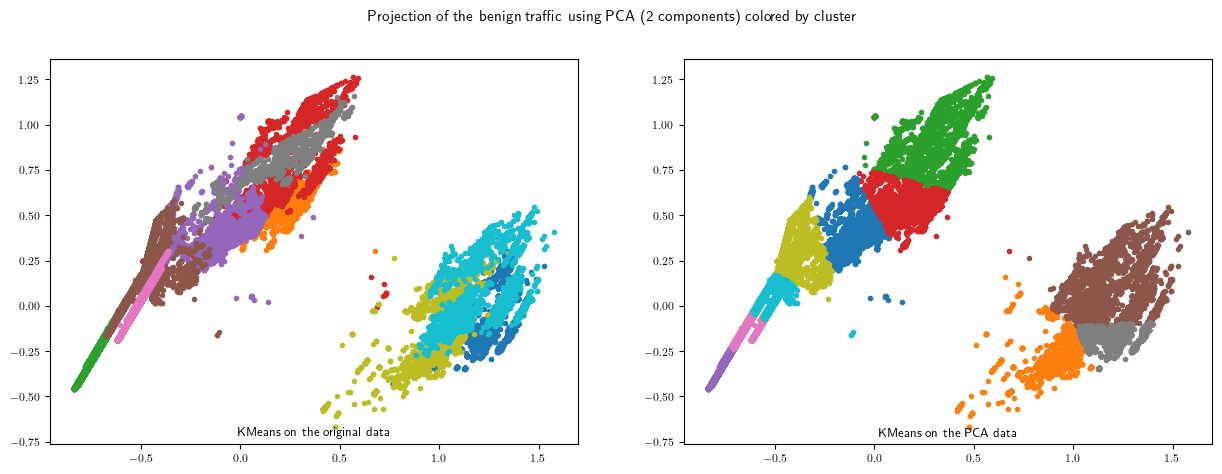

In [16]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15, 5))

# plot the pca colored by the cluster
for cluster in clusters["X"].unique():
    mask = clusters["X"] == cluster
    ax0.scatter(
        X_pca.loc[mask, "pca1"], X_pca.loc[mask, "pca2"], label=f"Cluster {cluster}"
    )
    ax0.set_title("KMeans on the original data")
    mask = clusters["X_pca"] == cluster
    ax1.scatter(
        X_pca.loc[mask, "pca1"], X_pca.loc[mask, "pca2"], label=f"Cluster {cluster}"
    )
    ax1.set_title("KMeans on the PCA data")


ax.legend()
fig.suptitle(
    "Projection of the benign traffic using PCA (2 components) colored by cluster"
)

In [17]:
# reindex the clusters by size
clusters_map = pd.DataFrame(
    pd.concat(
        [
            pd.Series(clusters["X"].value_counts().sort_values().index),
            pd.Series(clusters["X_pca"].value_counts().sort_values().index),
        ],
        axis=1,
    ),
    columns=["X", "X_pca"],
)

clusters["X"] = clusters["X"].map(
    {v: k for k, v in clusters_map["X"].to_dict().items()}
)
clusters["X_pca"] = clusters["X_pca"].map(
    {v: k for k, v in clusters_map["X_pca"].to_dict().items()}
)

counts = pd.DataFrame(
    [clusters["X"].value_counts(), clusters["X_pca"].value_counts()]
).T
counts.columns = ["X", "X_pca"]
counts.sort_index()

,X,X_pca
0,24793,37056
1,25670,38261
2,33623,54407
3,45410,56399
4,71969,59220
5,76663,85156
6,108346,130592
7,126444,133147
8,180131,141107
9,187574,145278


In [18]:
sum(counts["X"]), sum(counts["X_pca"])

(880623, 880623)

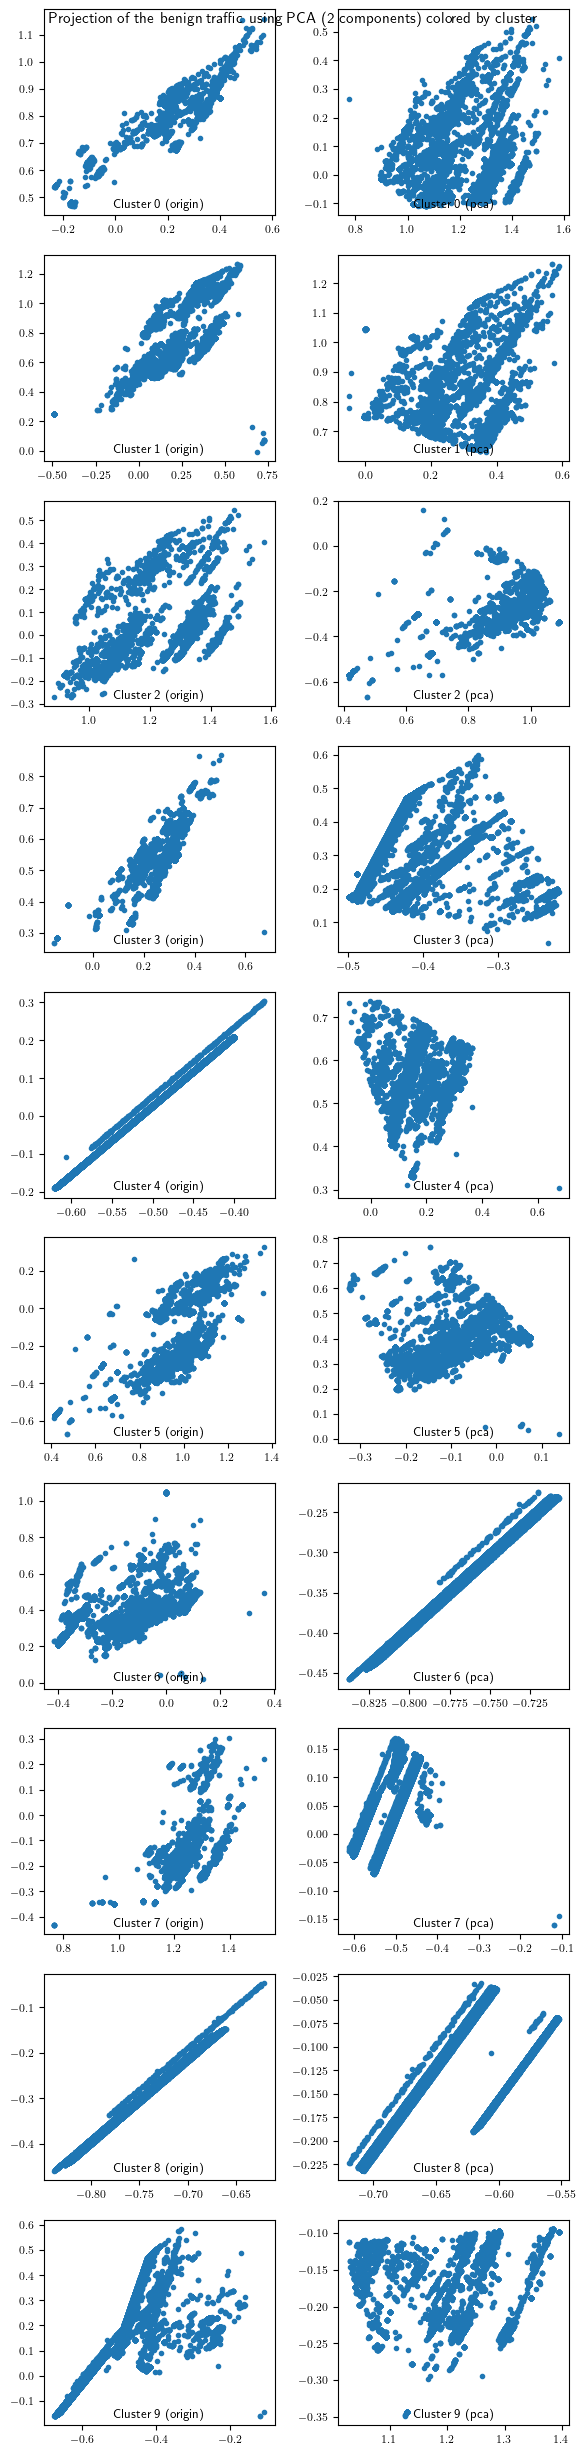

In [19]:
fig, axs = plt.subplots(10, 2, figsize=(6, 25))

for cluster in range(10):
    mask = clusters["X"] == cluster
    axs[cluster, 0].scatter(
        X_pca.loc[mask, "pca1"], X_pca.loc[mask, "pca2"], label=f"Cluster {cluster}"
    )
    axs[cluster, 0].set_title(f"Cluster {cluster} (origin)")
    mask = clusters["X_pca"] == cluster
    axs[cluster, 1].scatter(
        X_pca.loc[mask, "pca1"], X_pca.loc[mask, "pca2"], label=f"Cluster {cluster}"
    )
    axs[cluster, 1].set_title(f"Cluster {cluster} (pca)")

fig.suptitle(
    "Projection of the benign traffic using PCA (2 components) colored by cluster"
)
fig.tight_layout()
plt.show()